In [11]:
!pip install datasets evaluate rouge_score loralib peft --quiet


In [12]:
# 必要なライブラリをimport
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [13]:
model_name = "google/flan-t5-base"

# トークナイザを読み込み
tokenizer = T5Tokenizer.from_pretrained( model_name)
# LLMを読み込み
model = T5ForConditionalGeneration.from_pretrained( model_name).to(device)

In [14]:
# データセットをロード
dataset = load_dataset('knkarthick/dialogsum')

# 読み込まれたデータセットの概要を表示
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})



評価中: プロンプト1: ベースライン
プロンプト1: ベースライン:
rouge1: 0.2350
rouge2: 0.0669
rougeL: 0.2053
--------------

評価中: プロンプト2: 簡潔さを強調
プロンプト2: 簡潔さを強調:
rouge1: 0.2548
rouge2: 0.0811
rougeL: 0.2268
--------------

評価中: プロンプト3: 文長制約（3文以内）
プロンプト3: 文長制約（3文以内）:
rouge1: 0.2309
rouge2: 0.0673
rougeL: 0.2050
--------------

評価中: プロンプト4: 重要ポイント抽出
プロンプト4: 重要ポイント抽出:
rouge1: 0.2635
rouge2: 0.0865
rougeL: 0.2323
--------------

評価中: プロンプト5: 意図・結論に焦点
プロンプト5: 意図・結論に焦点:
rouge1: 0.2493
rouge2: 0.0807
rougeL: 0.2172
--------------

評価中: プロンプト6: 具体情報を強調
プロンプト6: 具体情報を強調:
rouge1: 0.2556
rouge2: 0.0496
rougeL: 0.2098
--------------

評価中: プロンプト7: 箇条書き形式
プロンプト7: 箇条書き形式:
rouge1: 0.2329
rouge2: 0.0712
rougeL: 0.2008
--------------

評価中: プロンプト8: 質問形式
プロンプト8: 質問形式:
rouge1: 0.2110
rouge2: 0.0603
rougeL: 0.1728
--------------

========== ROUGEスコア比較表 ==========
             プロンプト ROUGE-1 ROUGE-2 ROUGE-L
    プロンプト1: ベースライン  0.2350  0.0669  0.2053
    プロンプト2: 簡潔さを強調  0.2548  0.0811  0.2268
プロンプト3: 文長制約（3文以内）  0.2309  0.0673  0.2050
  プ

/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3266063356.py:201: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
 

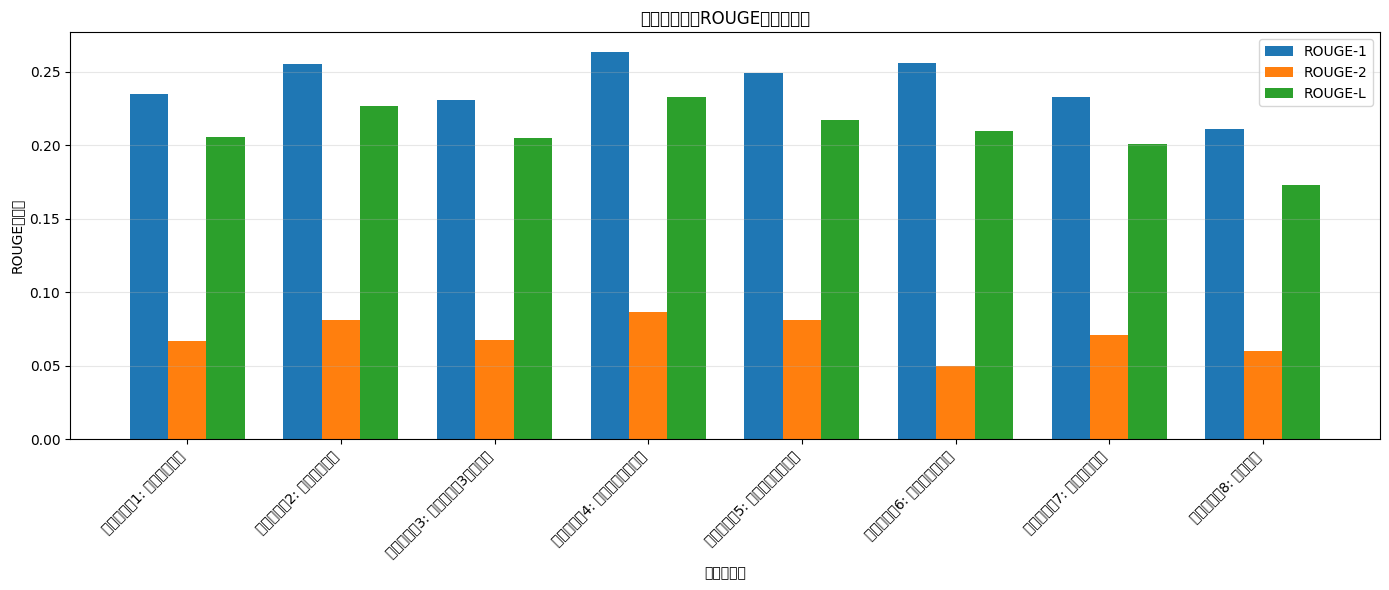

In [15]:


# データセット抜粋（最初の100件）
test_data = dataset['test'][0:100]

# ===== プロンプトバリエーション定義 =====

def get_summary_prompt_v1(dialogue):
    """プロンプト1: ベースライン"""
    return f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

def get_summary_prompt_v2(dialogue):
    """プロンプト2: 簡潔さを強調"""
    return f"""
Provide a brief summary of the following conversation in one or two sentences.

{dialogue}

Summary:
"""

def get_summary_prompt_v3(dialogue):
    """プロンプト3: 文長制約（3文以内）"""
    return f"""
Summarize the following conversation in 3 sentences or less.

{dialogue}

Summary:
"""

def get_summary_prompt_v4(dialogue):
    """プロンプト4: 重要ポイント抽出"""
    return f"""
Extract the key points from the following conversation and summarize them.

{dialogue}

Summary:
"""

def get_summary_prompt_v5(dialogue):
    """プロンプト5: 意図・結論に焦点"""
    return f"""
Summarize the following conversation, focusing on the participants' intentions and conclusions.

{dialogue}

Summary:
"""

def get_summary_prompt_v6(dialogue):
    """プロンプト6: 具体情報を強調"""
    return f"""
Summarize the following conversation. Include who said what and what actions were discussed.

{dialogue}

Summary:
"""

def get_summary_prompt_v7(dialogue):
    """プロンプト7: 箇条書き形式"""
    return f"""
Summarize the following conversation as bullet points.

{dialogue}

Summary:
"""

def get_summary_prompt_v8(dialogue):
    """プロンプト8: 質問形式"""
    return f"""
Read the following conversation and answer: What was discussed and what was decided?

{dialogue}

Summary:
"""

# ===== 評価関数 =====

def rouge_compute(rouge, title, human_baseline_summaries, predictions):
    """ROUGEスコアを計算"""
    model_results = rouge.compute(
        predictions=predictions,
        references=human_baseline_summaries[0:len(predictions)],
        use_aggregator=True,
        use_stemmer=True,
    )
    model_results['title'] = title
    return model_results

def print_result(result):
    """結果を整形して表示"""
    print(f"{result['title']}:\nrouge1: {result['rouge1']:.4f}\nrouge2: {result['rouge2']:.4f}\nrougeL: {result['rougeL']:.4f}\n--------------")

def evaluate_multiple_prompts(dataset, tokenizer, model):
    """複数のプロンプトで評価を実行"""
    rouge = evaluate.load('rouge')

    prompt_functions = [
        ("プロンプト1: ベースライン", get_summary_prompt_v1),
        ("プロンプト2: 簡潔さを強調", get_summary_prompt_v2),
        ("プロンプト3: 文長制約（3文以内）", get_summary_prompt_v3),
        ("プロンプト4: 重要ポイント抽出", get_summary_prompt_v4),
        ("プロンプト5: 意図・結論に焦点", get_summary_prompt_v5),
        ("プロンプト6: 具体情報を強調", get_summary_prompt_v6),
        ("プロンプト7: 箇条書き形式", get_summary_prompt_v7),
        ("プロンプト8: 質問形式", get_summary_prompt_v8),
    ]

    human_baseline_summaries = dataset['summary']
    all_results = []
    all_summaries = {}

    for prompt_name, prompt_func in prompt_functions:
        print(f"\n評価中: {prompt_name}")
        model_summaries = []

        for dialogue in dataset['dialogue']:
            prompt = prompt_func(dialogue)
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids
            output_ids = model.generate(input_ids.to(model.device))[0]
            output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
            model_summaries.append(output_text)

        model_result = rouge_compute(rouge, prompt_name, human_baseline_summaries, model_summaries)
        all_results.append(model_result)
        all_summaries[prompt_name] = model_summaries
        print_result(model_result)

    return all_results, all_summaries

# ===== 結果表示関数 =====

def create_comparison_table(results):
    """結果を表形式で比較"""
    df = pd.DataFrame([
        {
            'プロンプト': r['title'],
            'ROUGE-1': f"{r['rouge1']:.4f}",
            'ROUGE-2': f"{r['rouge2']:.4f}",
            'ROUGE-L': f"{r['rougeL']:.4f}",
        }
        for r in results
    ])
    return df

def compare_outputs_for_sample(sample_idx, dataset, summaries_dict):
    """特定サンプルの出力を比較"""
    print(f"\n========== サンプル {sample_idx} の比較 ==========")
    print(f"\n【元の対話】\n{dataset['dialogue'][sample_idx]}")
    print(f"\n【参照要約（正解）】\n{dataset['summary'][sample_idx]}")

    for prompt_name, summaries in summaries_dict.items():
        print(f"\n【{prompt_name}】\n{summaries[sample_idx]}\n文字数: {len(summaries[sample_idx])}")

# ===== メイン実行 =====

# 評価実行
results, summaries_dict = evaluate_multiple_prompts(test_data, tokenizer, model)

# 比較表を表示
comparison_df = create_comparison_table(results)
print("\n========== ROUGEスコア比較表 ==========")
print(comparison_df.to_string(index=False))

# サンプル出力の比較
for idx in [0, 10, 50]:
    compare_outputs_for_sample(idx, test_data, summaries_dict)

    # ROUGEスコアの変化をグラフ化
def plot_rouge_comparison(results):
    prompt_names = [r['title'] for r in results]
    rouge1_scores = [r['rouge1'] for r in results]
    rouge2_scores = [r['rouge2'] for r in results]
    rougeL_scores = [r['rougeL'] for r in results]

    x = np.arange(len(prompt_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, rouge1_scores, width, label='ROUGE-1')
    ax.bar(x, rouge2_scores, width, label='ROUGE-2')
    ax.bar(x + width, rougeL_scores, width, label='ROUGE-L')

    ax.set_xlabel('プロンプト')
    ax.set_ylabel('ROUGEスコア')
    ax.set_title('プロンプト別ROUGEスコア比較')
    ax.set_xticks(x)
    ax.set_xticklabels(prompt_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('rouge_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# グラフを作成
plot_rouge_comparison(results)